In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import sys
sys.path.append('../scripts')

In [3]:
SEED = 42
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [5]:
from training_nn import training_cnn
from evaluation import evaluate_model_rnn, plot_loss, evaluate_model_cnn
from process_data import get_desc

### Training block

#### Models block

In [143]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3,
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, 
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, 
                      stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), nn.ReLU()
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction


class RNN(nn.Module):
    def __init__(self, input_size=41, seq_lentgth=24, hidden_size=140, num_layers=10, num_classes=1):
        super().__init__()
        self.embed = nn.Embedding(5, seq_lentgth, dtype=torch.float32)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=True)
        self.linear1 = nn.Linear(2*seq_lentgth*hidden_size, 100)
        self.linear2 = nn.Linear(100, num_classes)

    def forward(self, x, ab_idx):
        embed = self.embed(ab_idx)
        embed = torch.unsqueeze(embed, 2)
        embed = torch.cat((embed, x), dim=2)
        x, _ = self.rnn(embed)
        x = x.reshape(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

###### Insert path to physical features datasets

In [ ]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [57]:
train = pd.read_csv(train_path)

In [58]:
test = pd.read_csv(test_path)

In [59]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [99]:
def get_data(train, test, samples = 200, target_ab = None):
    target_df = train.loc[train['Antibody'] == target_ab]
    rest_df = train.loc[train['Antibody'] != target_ab]
    target_test = test.loc[test['Antibody'] == target_ab]
    
    sample_target = target_df.sample(n=samples, random_state=SEED)
    
    train_target = sample_target.iloc[:samples//2, :]
    valid_target = sample_target.iloc[samples//2:, :]
    
    return train_target, valid_target, target_test, rest_df

In [100]:
train_target, valid_target, target_test, rest_df = get_data(train, test, target_ab = 'REGN33')

In [ ]:
map_target = {'LY16': 0, 'REGN33': 1, 'REGN87': 2, 'LY555': 3, 'ACE2': 4}

In [74]:
class Ag_seq(Dataset):
    def __init__(self, df, map_target):
        self.df = df
        self.ab_map = map_target
        
        
    def __len__(self):
        return len(self.df)
    

    def _code_ab(self, ab):
        pos = self.ab_map[ab]
        ab_feature = np.zeros((24, 1))
        ab_feature[pos] = 1
        return ab_feature
        
    
    def __getitem__(self, idx):
        phys_features = self.df.repr.iloc[idx]
        ab = self.df.Antibody.iloc[idx]
        ab_feature = self._code_ab(ab)
        features = np.concatenate((phys_features, ab_feature), axis=1)
        label = self.df.Label.iloc[idx]
        return features, label

In [146]:
def prepare_dataloader(df, dataset_torch, batch_size = 5, shuffle=True):
    dataset = dataset_torch(df, map_target)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = 2)
    return dataloader

In [77]:
trainloader_rest = prepare_dataloader(rest_df, Ag_seq, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, Ag_seq, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Ag_seq, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Ag_seq, shuffle=False, batch_size=50)

In [78]:
model = CNNModel(41, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


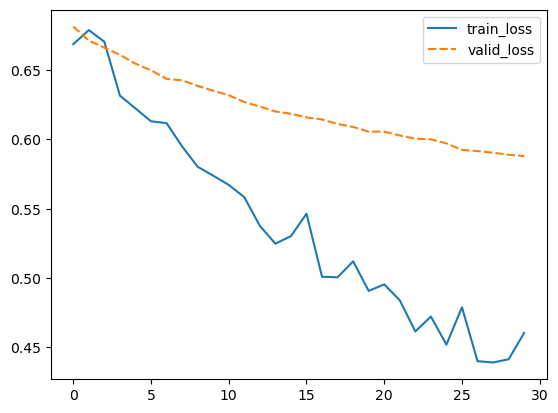

In [79]:
plot_loss(loss_train_hist, loss_valid_hist)

In [80]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.642884,0.332184,0.875543,0.481634,0.810655


In [90]:
class Ag_ab_seq(Dataset):
    def __init__(self, df):
        self.df = df
        self.ab_map = {'LY16': 0, 'REGN33': 1, 'REGN87': 2, 'LY555': 3}


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        features = self.df.repr.iloc[idx]
        ab = self.ab_map[self.df.Antibody.iloc[idx]]
        label = self.df.Label.iloc[idx]
        return [features, ab, label]

In [91]:
validloader = prepare_dataloader(valid_target, Ag_ab_seq, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Ag_ab_seq, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Ag_ab_seq, shuffle=False, batch_size=50)

In [94]:
model = RNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


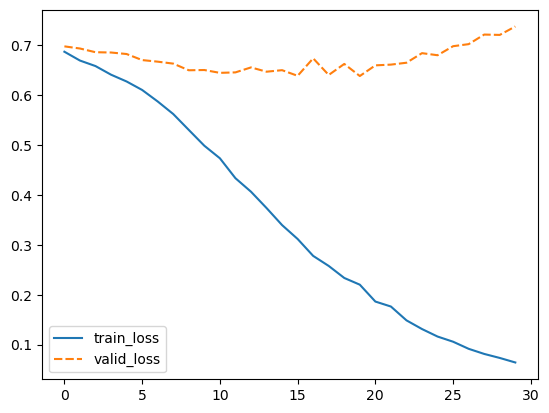

In [95]:
plot_loss(loss_train_hist, loss_valid_hist)

In [96]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.693943,0.578774,0.751313,0.653853,0.787679


### One hot encoding

In [102]:
train = pd.read_csv("/kaggle/input/ml-mutational-learning/whole_train.csv")
test = pd.read_csv("/kaggle/input/ml-mutational-learning/whole_test.csv")

In [105]:
train_target, valid_target, target_test, rest_df = get_data(train, test, target_ab = 'REGN33')

In [147]:
class Onehot_df(Dataset):

    def __init__(self, df, map_target):
        self.df = df
        self.ab_map = map_target


    @staticmethod
    def _encode_seq(sequence):
        alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        char_to_int = dict((c, i) for i, c in enumerate(alphabet))
        integer_encoded = [char_to_int[char] for char in sequence]
        onehot_encoded = list()
        for value in integer_encoded:
            letter = [0 for _ in range(len(alphabet))]
            letter[value] = 1
            onehot_encoded.append(letter)
        return np.array(onehot_encoded)
    
    @staticmethod
    def _code_ab(ab):
        pos = ab_map[ab]
        ab_feature = np.zeros((24, 1))
        ab_feature[pos] = 1
        return ab_feature
    
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        onehot_features = self._encode_seq(self.df.junction_aa.iloc[idx])
        ab = self.df.Antibody.iloc[idx]
        ab_feature = self._code_ab(ab)
        features = np.concatenate((onehot_features, ab_feature), axis=1)
        label = self.df.Label.iloc[idx]
        return features, label

In [148]:
validloader = prepare_dataloader(valid_target, Onehot_df, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Onehot_df, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Onehot_df, shuffle=False, batch_size=50)

In [149]:
model = CNNModel(21, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


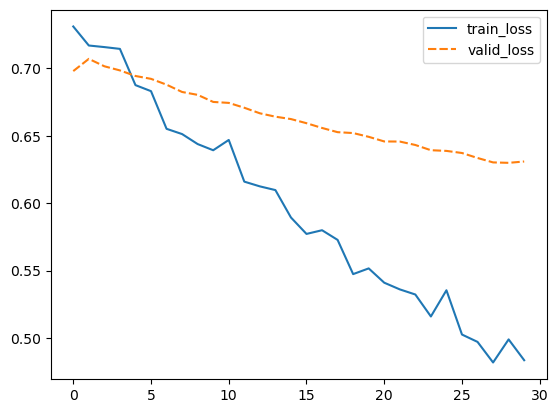

In [150]:
plot_loss(loss_train_hist, loss_valid_hist)

In [151]:
evaluate_model_cnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.569846,0.172962,0.835022,0.286566,0.74732


In [152]:
class Ab_encode(Onehot_df):
    def __getitem__(self, idx):
        onehot_features = self._encode_seq(self.df.junction_aa.iloc[idx])
        ab = self.ab_map[self.df.Antibody.iloc[idx]]
        label = self.df.Label.iloc[idx]
        return [onehot_features, ab, label]
    

In [153]:
validloader = prepare_dataloader(valid_target, Ab_encode, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Ab_encode, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Ab_encode, shuffle=False, batch_size=50)

In [154]:
model = RNN(input_size=21, seq_lentgth=24, hidden_size=140, num_layers=10, num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


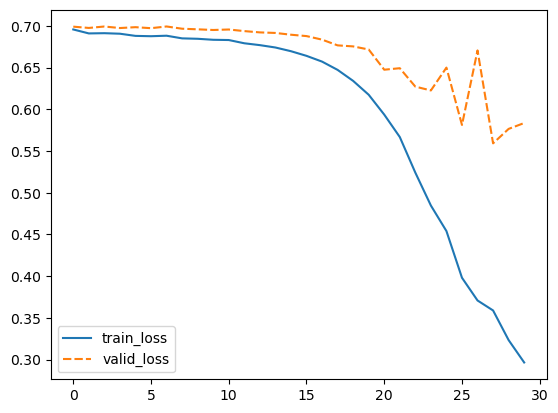

In [155]:
plot_loss(loss_train_hist, loss_valid_hist)

In [156]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.719194,0.592026,0.793332,0.678053,0.812496



#### Generating embedding belonging special target increase performance model in case of RNN model. 

#### Let's evaluate performce algoritm to add sequence of other antibodies.

In [185]:
train_target, valid_target, target_test, rest_df = get_data(train, test, target_ab = 'LY555')

In [193]:
ace_2 = rest_df[rest_df['Antibody']=='ACE2']
ace_2_subset = ace_2.sample(n=10000, random_state = SEED)

In [194]:
trainloader_rest = prepare_dataloader(ace_2_subset, Ab_encode, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, Ab_encode, shuffle=True, batch_size=10)

In [195]:
model = RNN(input_size=21, seq_lentgth=24, hidden_size=140, num_layers=10, num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_rest, validloader)

100%|██████████| 30/30 [14:31<00:00, 29.06s/it]


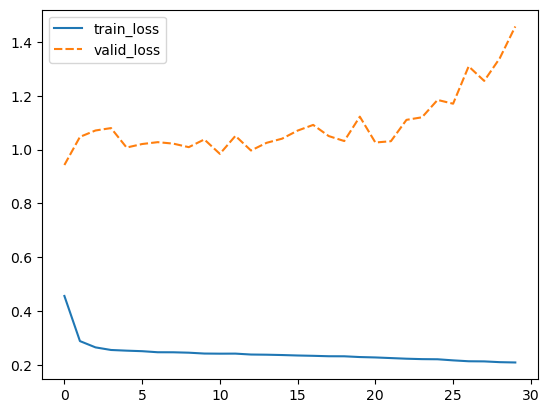

In [196]:
plot_loss(loss_train_hist, loss_valid_hist)

In [197]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.509582,0.98786,0.504632,0.668018,0.530454


In [198]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)

In [199]:
model_copy = copy_model(model, 21, 24, 140, 10, 1)

In [201]:
LY16 = rest_df[rest_df['Antibody']=='LY16']
LY16_subset = LY16.sample(n=10000, random_state = SEED)

In [202]:
trainloader_rest = prepare_dataloader(LY16_subset, Ab_encode, shuffle=True, batch_size=10)

In [203]:
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model_copy, criterion, optimizer, num_epochs, trainloader_rest, validloader)

100%|██████████| 30/30 [14:35<00:00, 29.19s/it]


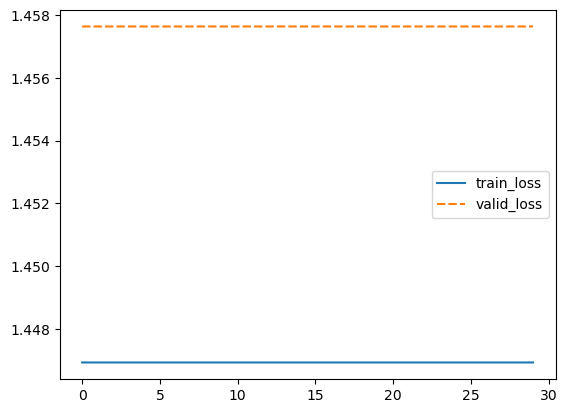

In [204]:
plot_loss(loss_train_hist, loss_valid_hist)

In [205]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.509582,0.98786,0.504632,0.668018,0.530454


Ace2 data increase recall for LY555 data.